# BTE TRAPI Results Summary

Goal: Make a diff-able report for a BTE TRAPI results file.

We observed variability between identical BTE queries via the Benchmarks tool. This notebook and the functions below help organize information we thought to be useful for figuring out where differences are occuring, as to focus our efforts for finding the source of this variability. It also details an example analysis on two inconsistent BTE results files.

In [1]:
import json

In [2]:
# summary stats as shown above for single bte query result file
def TRAPI_summary(filepath):
    
    output_dict = {
        'summary_stats': {},
        'logs': {
            'errors': [],
            'execution_summaries': []
        },
        'infores': {},
        'results': {}
    }
    
    with open(filepath) as fp:
        file = json.load(fp)
    
        # summary stats
        message = file['message']
        output_dict['summary_stats']['n_nodes'] = len(message['knowledge_graph']['nodes'])
        output_dict['summary_stats']['n_edges'] = len(message['knowledge_graph']['edges'])
        output_dict['summary_stats']['n_results'] = len(message['results'])
        output_dict['summary_stats']['n_aux_graphs'] = len(message['auxiliary_graphs'])

        # logs
        errors = []
        ex_summaries = []
        for log in file['logs']:
            if log['level'] == 'ERROR':
                errors.append(str(log['message']))
            if 'Execution Summary:' in log['message']:
                ex_summaries.append(str(log['message']))

        output_dict['logs']['errors'] = errors
        output_dict['logs']['excecution_summaries'] = ex_summaries

        # infores
        infores_dict = {}
        for edge_id, info in message['knowledge_graph']['edges'].items():
            source = info['sources'][0]['resource_id']
            if (source in infores_dict):
                infores_dict[source] += 1
            else:
                infores_dict[source] = 1

        infores_dict = dict(sorted(infores_dict.items()))
        output_dict['infores'] = infores_dict

        # scores
        results = file['message']['results']
        results_dict = {}
        for result in results:
            # subject = drug, object = disease
            subject_id = result['node_bindings']['chebi'][0]['id']
            object_id = result['node_bindings']['disease_umls'][0]['id']
            score = result['analyses'][0]['score']

            result_score = {subject_id + '-' + object_id: score}
            results_dict.update(result_score)

        results_dict = dict(sorted(results_dict.items()))
        output_dict['results'] = results_dict
        
    return output_dict

In [3]:
# writes above summary as a txt file -> diff on unix
def summary_txt(path, trapi_summary):
    with open(path, 'w') as text:
        text.write('== SUMMARY STATS ==\n')
        for att, count in trapi_summary['summary_stats'].items():
            text.write(f'{att}: {count}\n')

        text.write('\n== LOGS ==\n')
        text.write('Errors:\n')
        text.write('\n'.join(trapi_summary['logs']['errors']))
        text.write('\nExecution Summaries:\n')
        text.write('\n'.join(trapi_summary['logs']['excecution_summaries']))

        text.write('\n\n== INFORES ==\n')
        for source, count in trapi_summary['infores'].items():
            text.write(f'{source}: {count}\n')

        text.write('\n== RESULTS ==\n')
        for result, score in trapi_summary['results'].items():
            text.write(f'{result}: {score}\n')

In [4]:
# same as summary_txt but prints it in the notebook output
def print_summary(trapi_summary):
    print('== SUMMARY STATS ==')
    for att, count in trapi_summary['summary_stats'].items():
        print(f'{att}: {count}')
    
    print('\n== LOGS ==')
    print('Errors:', *trapi_summary['logs']['errors'], sep = "\n")
    print('\nExecution Summaries:', *trapi_summary['logs']['excecution_summaries'], sep = "\n")
    
    print('\n== INFORES ==')
    for source, count in trapi_summary['infores'].items():
        print(f'{source}: {count}')
    
    print('\n== RESULTS ==')
    for result, score in trapi_summary['results'].items():
        print(f'{result}: {score}')

---

# Analysis and Results

Below is an example of 2 BTE results files from identical queries that gave different results. While the analysis over the entire benchmark results folders is commented out (and the files not included in the repository), the two raw results files where inconsistencies were observed are included in [this repository](https://github.com/ngk5/trapi-summary-tool).

We first observed variability in BTE results while using the [Benchmarks](https://github.com/TranslatorSRI/Benchmarks/tree/87da1baffc0bd69d7a32db8a278122cb1960ae8f) tool, so I started by making 2 identical DrugCentral_creative `benchmarks_fetch` calls using the commands below on a local instance of BTE ([this version](https://github.com/biothings/biothings_explorer/tree/d14ee868b86e6efa6a2fbfff56f1c4a9e860316d)). 

- To start my local BTE: 

        SMARTAPI_SYNC=true API_OVERRIDE=true REDIS_KEY_EXPIRE_TIME=100000 npm start redis

- Benchmark fetch calls: 

        benchmarks_fetch DrugCentral_creative bte_local output/run_1

        benchmarks_fetch DrugCentral_creative bte_local output/run_2
        
Then I compared TRAPI results summary reports for all pairs of queries across runs 1 and 2. Using Benchmarks is also a fast and systematic way to have 50 *expected-to-be-identical* pairs of files to test for inconsistent results. I did this comparison within-notebook using [jsondiff](https://github.com/xlwings/jsondiff/tree/68862103b2b79f7a95bdceb6dbe02d14c6ec8334).

In [5]:
from jsondiff import diff
import matplotlib.pyplot as plt

In [6]:
# diff two bte benchmark results folders within notebook -> quick check for inconsistent runs based on the summary stats
# note: jsondiff symmetric compares keys and values, prints differences in a list [r1, r2]
def compare_benchmarks(path_1, path_2):
    import os
    
    # matches by filenames in path_1 -> should not be any extra json files in that directory
    filenames = [file for file in os.listdir(path_1) if file.endswith('.json')]

    diffs = {}
    for file in filenames:
        filepath_1 = os.path.join(path_1, file)
        filepath_2 = os.path.join(path_2, file)
        t1 = TRAPI_summary(filepath_1)
        t2 = TRAPI_summary(filepath_2)

        diffs[file] = diff(t1, t2, syntax='symmetric')
        
    return diffs

In [7]:
#compare_benchmarks('run_1', 'run_2')

In the above test run, only 1 query pair out of the 50 had inconsistent results: `DrugCentral_creative.treats.UMLS:C0233794`.


## TRAPI results comparison of `DrugCentral_creative.treats.UMLS:C0233794`

In [8]:
# run 1 (10/5)

run_1_file = 'run_1_DrugCentral_creative.treats.UMLS:C0233794.json'
run_1 = TRAPI_summary(run_1_file)
summary_txt('run_1_summary.txt', run_1)
print_summary(run_1)

== SUMMARY STATS ==
n_nodes: 848
n_edges: 17876
n_results: 500
n_aux_graphs: 1041

== LOGS ==
Errors:

Execution Summaries:
[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (0/0) queries (1 cached qEdges) returned results from (4) unique APIs 
[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (0/0) queries (2 cached qEdges) returned results from (6) unique APIs 
Execution Summary: (848) nodes / (17876) edges / (500) results; (0/6) queries (3 cached qEdges) returned results from (8) unique APIs 

== INFORES ==
infores:aeolus: 12
infores:biothings-explorer: 928
infores:chembl: 11
infores:dgidb: 367
infores:disgenet: 339
infores:monarchinitiative: 89
infores:semmeddb: 187
infores:text-mining-provider-targeted: 15938
infores:umls: 5

== RESULTS ==
CHEMBL.COMPOUND:CHEMBL1624-MONDO:0001185: 0.9978025378541506
CHEMBL.COMPOUND:CHEMBL242948-MONDO:0001185: 0.9297103071984134
CHEMBL.COMPOUND:CHEMBL274323-MONDO:0001185: 0.9923510327107254
CH

In [9]:
# run 2 (10/5)

run_2_file = 'run_2_DrugCentral_creative.treats.UMLS:C0233794.json'
run_2 = TRAPI_summary(run_2_file)
summary_txt('run_2_summary.txt', run_2)
print_summary(run_2)

== SUMMARY STATS ==
n_nodes: 848
n_edges: 17879
n_results: 500
n_aux_graphs: 1041

== LOGS ==
Errors:

Execution Summaries:
[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (17/32) queries returned results from (4) unique APIs 
[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (33/47) queries returned results from (6) unique APIs 
Execution Summary: (848) nodes / (17879) edges / (500) results; (50/85) queries returned results from (8) unique APIs 

== INFORES ==
infores:aeolus: 12
infores:biothings-explorer: 928
infores:chembl: 11
infores:dgidb: 369
infores:disgenet: 339
infores:monarchinitiative: 89
infores:semmeddb: 187
infores:text-mining-provider-targeted: 15939
infores:umls: 5

== RESULTS ==
CHEMBL.COMPOUND:CHEMBL1624-MONDO:0001185: 0.9978025378541506
CHEMBL.COMPOUND:CHEMBL242948-MONDO:0001185: 0.9297103071984134
CHEMBL.COMPOUND:CHEMBL274323-MONDO:0001185: 0.9923510327107254
CHEMBL.COMPOUND:CHEMBL514409-MONDO:0001185: 0.9338

In [10]:
test_diff = diff(run_1, run_2, syntax='symmetric', marshal=True) # marshal=True for diff keys as strings
test_diff

{'summary_stats': {'n_edges': [17876, 17879]},
 'logs': {'excecution_summaries': [['[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (0/0) queries (1 cached qEdges) returned results from (4) unique APIs ',
    '[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (0/0) queries (2 cached qEdges) returned results from (6) unique APIs ',
    'Execution Summary: (848) nodes / (17876) edges / (500) results; (0/6) queries (3 cached qEdges) returned results from (8) unique APIs '],
   ['[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (17/32) queries returned results from (4) unique APIs ',
    '[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (33/47) queries returned results from (6) unique APIs ',
    'Execution Summary: (848) nodes / (17879) edges / (500) results; (50/85) queries returned results from (8) unique APIs ']]},
 'infores': {'infores:dgidb': [367, 369],
  'infores:text

Notable differences from the summary report diff:

- The number of edges in the final knowledge graphs are different (17876 vs 17879) 
- Excecution summaries are similar (same number of nodes, edges, and results in the individual templates), but there is a differnce in qEdge caching
- Scores are slightly different for many (366/500) results
- There are 3 unique IDs to each file (results returned in one run but not in the other)

### Different execution summary logs

In [11]:
# execution summary logs from TRAPI summary
print('unique excecution summaries to run 1:\n')
print('\n\n'.join(test_diff['logs']['excecution_summaries'][0]), '\n\n')
print('unique excecution summaries to run 2:\n') 
print('\n\n'.join(test_diff['logs']['excecution_summaries'][1]))

unique excecution summaries to run 1:

[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (0/0) queries (1 cached qEdges) returned results from (4) unique APIs 

[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (0/0) queries (2 cached qEdges) returned results from (6) unique APIs 

Execution Summary: (848) nodes / (17876) edges / (500) results; (0/6) queries (3 cached qEdges) returned results from (8) unique APIs  


unique excecution summaries to run 2:

[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (17/32) queries returned results from (4) unique APIs 

[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (33/47) queries returned results from (6) unique APIs 

Execution Summary: (848) nodes / (17879) edges / (500) results; (50/85) queries returned results from (8) unique APIs 


The main difference, beside number of edges in the final execution summary, are cached qEdges. 

However, I don't think this caching is the source of variability. In a subsequent test run, the execution summaries included information about qEdge caching (identical summaries as run 1 above) but the number of edges and all results scores were identical to those in run 2. Therefore, I decided to look more into the score differences themselves and the edges of auxiliary graphs.

After discussion, my understanding is that the cached qEdges include specific queries and results, so if a later API call is identical to one in the cache, results will be returned without querying (faster, more reproducible). Ideally, the 1 cached qEdge in Template 1 of run 1 is identical to the 17/32 queries in Template 1 of run 2.

Skimming the logs with level `"DEBUG"` (which includes successful GET and POST requests to APIs), run 2 had many more successful GET and POST logs than run 1. This makes sense, as BTE in run 2 no longer had cached qEdgs, and would need to requery the APIs to get the results. 

### Nonequal results scores

number of score differences: 366
min = 3.9968028886505635e-15
max = 0.005508338047103267


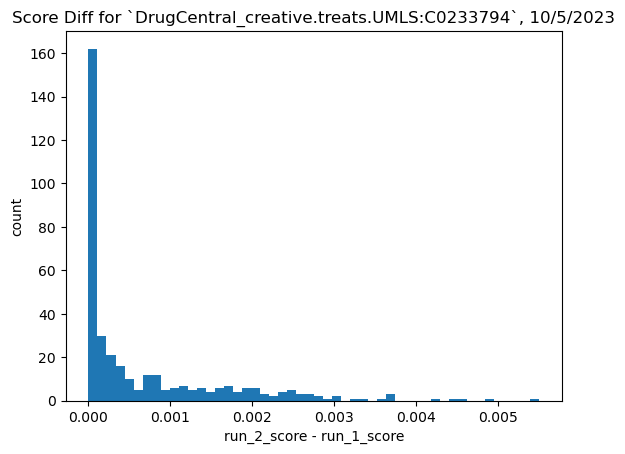

In [12]:
# distribution of score differences
diff_list = []
for scores in test_diff['results'].values():
    if type(scores) is list:
        score_diff = scores[1] - scores[0]  # run_2_score - run_1_score
        diff_list.append(score_diff)
        
print(f'number of score differences: {len(diff_list)}')
print(f'min = {min(diff_list)}')
print(f'max = {max(diff_list)}')

fig, ax = plt.subplots()
ax.hist(diff_list, bins = 50)
ax.set_title('Score Diff for `DrugCentral_creative.treats.UMLS:C0233794`, 10/5/2023')
ax.set_xlabel('run_2_score - run_1_score')
ax.set_ylabel('count')
plt.show()

Between the runs, 366/500 results have nonequal scores. The score from run 2 was always greater than that from run 1, which seems to align with run 2 having a greater number of edges as well. The scores also seem to vary minimally, with differences ranging between 3.997e-15 and 0.0055, indicating that there is a small difference between the components making up the scores; potentially a single edge?

### Unique results

In [13]:
# unique results in each file
print('unique results to run 1:\n', 
      json.dumps(test_diff['results']['$delete'], indent = 2), '\n')
print('unique results to run 2:\n', 
      json.dumps(test_diff['results']['$insert'], indent = 2))

unique results to run 1:
 {
  "PUBCHEM.COMPOUND:135398641-MONDO:0001185": 0.92072232179806,
  "PUBCHEM.COMPOUND:39040-MONDO:0001185": 0.92072232179806,
  "PUBCHEM.COMPOUND:5280805-MONDO:0001185": 0.92072232179806
} 

unique results to run 2:
 {
  "CHEMBL.COMPOUND:CHEMBL517712-MONDO:0001185": 0.9207401802709774,
  "PUBCHEM.COMPOUND:42611257-MONDO:0001185": 0.9242935360093549,
  "PUBCHEM.COMPOUND:5281243-MONDO:0001185": 0.9230970467810193
}


Each file has 3 unique results. One of our hypotheses was that different results being included in the final knowledge graph may be driving the different number of total edges. Specifically, we thought that nondeterministic results sorting of ties at the 500-results truncation cutoff may be especially relevant. The order of results must be the same for the truncation to remove the same results between identical runs, otherwise the bottom *n* results will be removed without consideration.

The results unique to run 1 all have the same score of `0.92072232179806`, which is also the minimum score across all results (i.e. the score of the 500th result in the file). This supports our hypothesis that perhaps in run 2, these 3 results were found but happened to be ranked below 500 due to the random order of tied results, and were thus truncated. However, the results unique to run 2 do not all have the same score, nor is it the minimum score. 


## Analysis of unique edge IDs

In [14]:
# unique edges between the 2 runs
with open(run_1_file) as file:
    edges_1 = {edge for edge in json.load(file)['message']['knowledge_graph']['edges'].keys()}
    
with open(run_2_file) as file:
    edges_2 = {edge for edge in json.load(file)['message']['knowledge_graph']['edges'].keys()}

edge_diff = diff(edges_1, edges_2, syntax='symmetric', marshal=True)

In [15]:
print(len(edge_diff['$discard']), 'edges are unique to run 1.')
edge_diff['$discard']

46 edges are unique to run 1.


{'0358ad9b7f06a4873ecc3b7a98113db8',
 '0562782c369c2d3569d8a6a9874a4d16',
 '0820bdd9921ffa637ffe29c3184da79c',
 '097c3d5b9bd85b290b7789cc5a6a94b3',
 '0cdba9481d028644e62e6b2a183becc5',
 '15c69262503e5ac731a00c62f5d53e9f',
 '17e4b4ffec147c3e03812eb151fd14e8',
 '1e73836bc52d5a569992f135e2babbcb',
 '23a3f65ee5938be0b0aa2ac62de27a1c',
 '2e2f8e62b546b2913f5d03fb493691d2',
 '381fb76f98408c89a6ececec5fbce323',
 '455d45f7d5cbb6d18f3cce83b408edef',
 '45e7a4e4d371be1cdd9d0287af1ac14d',
 '4af3e8d509caadb1e9462dfb716761b5',
 '4b4b2fe8c07fd283a006eaf7532c36de',
 '5bebce267469bbbc8058fefb27a7e1c0',
 '5f5b17f450c30deb4561f00ca93ff5dc',
 '6087a1109b6295948d86118eca5a494d',
 '68cfe627825d16aa70d4ab75aeb7a5b7',
 '6f62c4261378d5bc1e2b5423a57ceba7',
 '7d68631ef9724487acc037d901a929f4',
 '815faf93f6e307f09ce47cfb622e88ac',
 '847140a6a094bbfffd44006f5c077366',
 '92a2195d819a9d1af31b6f5453ec57bc',
 '96ab5d0594fb7f04b62f1203ed5c78cb',
 '9b712dc5debe5a8939712321f210152a',
 'a8b9e8b0ae2df33824eb417c013d1bb3',
 

In [16]:
print(len(edge_diff['$add']), 'edges are unique to run 2.')
edge_diff['$add']

49 edges are unique to run 2.


{'02a6cc709f3d16a25c7e35d0abd4cdb0',
 '037d204eeceae26c54977de781f63bf1',
 '0a29a4e08c6c931a272ab8770ebdb95d',
 '100ceecee3d684f2661a9587897e47cb',
 '10c3b26dcd7e41eef5f7c04d0a730ce9',
 '1185f17a6294a3a125931ef7d796ba17',
 '1cc08ad5c3c2774b7c1a324c6d98dbeb',
 '28c5c88072e5f169d2d1e0c66d6ad7b7',
 '2fb46ddcf67d8d4db2bef8fe9ce83e13',
 '35c1ec71d6fa390dde3b285f8f480255',
 '36646d133d0287c918dbbd9ef6c6db10',
 '38cb56cc648724cafe654e3f568b8899',
 '46a746e231c3b9d651f26653584c8056',
 '4c695f0a0e6885fb77428dffee428be3',
 '542da7ded9207afc791a5e6582cab800',
 '5bed42996483c7abf9e30415108966f4',
 '619a4b1d8402e7d69a41ab0be6ee86e9',
 '62544fdcad9c985b1d96824f41b61863',
 '682f51e7abbe2fc45190ce2f31471bb2',
 '71458c9b83d407902b697965ba031d6d',
 '7372063d49fcc640fb088859530394df',
 '864a743773e7597b3013c8bd4fe3ab66',
 '86ad10db81cd149ff153a888b2d7fcc6',
 '8a491c36dd9e901653e1d5169712410e',
 '8b902e1ece3a9bc583a0053fee8b7fee',
 '956128e187c4c82960f7a9e9936f3d08',
 '9a664170fcf12e43654e2d4cd178d360',
 

There are 46 edges unique to run 1, and 49 edges unique to run 2. The edges starting with `inferred-` are the edge bindings for the 3 unique results of each file. These edges have an attribute in the support graphs, which is located in the auxiliary graphs section of the TRAPI results file. 

Below, I checked if the unique edges of the entire run are only used in the support graphs of the unique results, which I believe would then rule them out as causes for the score differences because they are not used in the scores of other results. This seems to be the case: **the unique edges are only used in the support graphs of the unique results.** I manually verified that the edge IDs did not appear elsewhere in the results file.

In [17]:
# unique edges of run 1 if they are not in a support graph of a unique result
unique_aux_edges_1 = ['inferred-PUBCHEM.COMPOUND:135398641-treats-MONDO:0001185',
                      'inferred-PUBCHEM.COMPOUND:39040-treats-MONDO:0001185',
                      'inferred-PUBCHEM.COMPOUND:5280805-treats-MONDO:0001185']

with open(run_1_file) as file:
    aux_graphs = json.load(file)['message']['auxiliary_graphs']
    unique_edges_1 = [edge for edge in edge_diff['$discard'] if edge not in unique_aux_edges_1]
    
    for aux_edge in unique_aux_edges_1:
        unique_results_edges = aux_graphs[f'{aux_edge}-support0']['edges']
        unique_edges_1 = [edge for edge in unique_edges_1 if edge not in unique_results_edges]
        
unique_edges_1

[]

In [18]:
# unique edges of run 2 if they are not in a support graph of a unique result
unique_aux_edges_2 = ['inferred-CHEMBL.COMPOUND:CHEMBL517712-treats-MONDO:0001185',
                      'inferred-PUBCHEM.COMPOUND:42611257-treats-MONDO:0001185',
                      'inferred-PUBCHEM.COMPOUND:5281243-treats-MONDO:0001185']
    
with open(run_2_file) as file:
    aux_graphs = json.load(file)['message']['auxiliary_graphs']
    unique_edges_2 = [edge for edge in edge_diff['$add'] if edge not in unique_aux_edges_2]
    
    for aux_edge in unique_aux_edges_2:
        unique_results_edges = aux_graphs[f'{aux_edge}-support0']['edges']
        unique_edges_2 = [edge for edge in unique_edges_2 if edge not in unique_results_edges]

unique_edges_2

[]

Similar findings when comparing auxiliary graphs: **the only unique auxiliary graphs are the support graphs for the unique results.**

In [19]:
# unique auxiliary graphs between the 2 runs
with open(run_1_file) as file:
    aux_1 = {edge for edge in json.load(file)['message']['auxiliary_graphs'].keys()}
    
with open(run_2_file) as file:
    aux_2 = {edge for edge in json.load(file)['message']['auxiliary_graphs'].keys()}

diff(aux_1, aux_2, syntax='symmetric')

{add: {'inferred-CHEMBL.COMPOUND:CHEMBL517712-treats-MONDO:0001185-support0',
  'inferred-PUBCHEM.COMPOUND:42611257-treats-MONDO:0001185-support0',
  'inferred-PUBCHEM.COMPOUND:5281243-treats-MONDO:0001185-support0'},
 discard: {'inferred-PUBCHEM.COMPOUND:135398641-treats-MONDO:0001185-support0',
  'inferred-PUBCHEM.COMPOUND:39040-treats-MONDO:0001185-support0',
  'inferred-PUBCHEM.COMPOUND:5280805-treats-MONDO:0001185-support0'}}

## Analysis of the logs

A key indicator of a faulty run is an error log message, usually a failed POST to an API. This is typically remedied when the query is rerun. However, these runs had no `"ERROR"`-level logs, as there are none noted in the TRAPI summary. Taking a closer look at the differences between other logs may still be insightful.

I first looked at the logs with level `"INFO"`. These include the execution summaries (compared above) and lists of APIs used for each template; differences in which would likely affect the results as BTE would be querying a different set of sources.

In [20]:
# "INFO" logs -> includes execution summaries and which APIs were called
with open(run_1_file) as file:
    info_logs_1 = {log['message'] for log in json.load(file)['logs'] if log['level'] == 'INFO'}
    
with open(run_2_file) as file:
    info_logs_2 = {log['message'] for log in json.load(file)['logs'] if log['level'] == 'INFO'}
    
info_diff = diff(info_logs_1, info_logs_2, syntax='symmetric', marshal=True)

In [21]:
print('unique to run 1:')
info_diff['$discard']

unique to run 1:


{'APIs: BioThings SEMMEDDB API, MyChem.info API, BioThings IDISK API, Text Mining Targeted Association API, BioLink API, MyDisease.info API, BioThings DISEASES API, BioThings DGIdb API',
 'Execution Summary: (848) nodes / (17876) edges / (500) results; (0/6) queries (3 cached qEdges) returned results from (8) unique APIs ',
 '[Template-1]: APIs: BioThings SEMMEDDB API, MyChem.info API, BioThings IDISK API, Text Mining Targeted Association API',
 '[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (0/0) queries (1 cached qEdges) returned results from (4) unique APIs ',
 '[Template-1]: eA execution: 0 queries (0 success/0 fail) and (1) cached qEdges return (348) records',
 '[Template-3]: APIs: BioLink API, MyDisease.info API, BioThings DISEASES API, BioThings SEMMEDDB API, BioThings DGIdb API, Text Mining Targeted Association API',
 '[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (0/0) queries (2 cached qEdges) returned results fr

In [22]:
print('unique to run 2:')
info_diff['$add']

unique to run 2:


{'APIs: MyChem.info API, BioThings IDISK API, BioThings SEMMEDDB API, Text Mining Targeted Association API, BioThings DISEASES API, MyDisease.info API, BioLink API, BioThings DGIdb API',
 'Execution Summary: (848) nodes / (17879) edges / (500) results; (50/85) queries returned results from (8) unique APIs ',
 '[Template-1]: APIs: MyChem.info API, BioThings IDISK API, BioThings SEMMEDDB API, Text Mining Targeted Association API',
 '[Template-1]: Execution Summary: (189) nodes / (406) edges / (186) results; (17/32) queries returned results from (4) unique APIs ',
 '[Template-1]: eA execution: 32 queries (32 success/0 fail) and (0) cached qEdges return (348) records',
 '[Template-3]: APIs: BioThings DISEASES API, MyDisease.info API, BioLink API, BioThings SEMMEDDB API, BioThings DGIdb API, Text Mining Targeted Association API',
 '[Template-3]: Execution Summary: (5101) nodes / (30022) edges / (4667) results; (33/47) queries returned results from (6) unique APIs ',
 '[Template-3]: eA execu

The lists of APIs are identical, just in a different order. The `eA` and `eB` executions seem different at first glance, however I think these differences are due to the cached qEdges. Since both runs returned that same number of results, I don't think any of these logs are truly different such that they contribute to the observed differences in scores or results.
For example: 

`'[Template-1]: eA execution: 32 queries (32 success/0 fail) and (0) cached qEdges return (348) records'`
`'[Template-1]: eA execution: 0 queries (0 success/0 fail) and (1) cached qEdges return (348) records'`

Next, I looked at the logs with level `"WARNING"`. These include terminating queries and lists of unavailable APIs, differences in which would likely affect returned results as described above.

In [23]:
# "WARNING" logs -> includes unavailable APIs
with open(run_1_file) as file:
    warning_logs_1 = {log['message'] for log in json.load(file)['logs'] if log['level'] == 'WARNING'}
    
with open(run_2_file) as file:
    warning_logs_2 = {log['message'] for log in json.load(file)['logs'] if log['level'] == 'WARNING'}

diff(warning_logs_1, warning_logs_2)

{add: {'[Template-3]: QEdge eA obtained 41267 records, exceeding maximum of 30000. Truncating records to 30000 and skipping remaining 867 (861 planned/6 paged) queries for this edge. Your query may be too general?'}}

Both runs had the same API exclusions overall and for all 3 templates: `'The following APIs were unavailable at the time of execution: Gene-List Network Enrichment Analysis, Service Provider TRAPI, Knowledge Collaboratory API'`. 

However, run 2 had the additional `"WARNING"`-level log above. This log seems to indicate that a number of queries were skipped, which may have contributed to different results (nodes and/or edges) being returned. It's interesting then that the end number of nodes is identical between the runs, there are only 3 unique results in each file, and that the number of edges is very similar. After discussion, this may indicate a silent failed API call in run 1, which returned 0 records but didn't log as an `"ERROR"`, meaning the 30000 record maximum was not reached and other queries in the queue were not skipped.

Finally, I looked at logs with level `"DEBUG"`. These include successful requests to APIs, metaKG information, and scoring information.

In [24]:
# "DEBUG" logs -> includes successful posts to APIs (check for same number of submitted IDs and returned results)
# many logs were different only because of different run times -> removed using .split('took')[0]
with open(run_1_file) as file:
    debug_logs_1 = [log['message'].split('took')[0] for log in json.load(file)['logs'] if log['level'] == 'DEBUG']

with open(run_2_file) as file:
    debug_logs_2 = [log['message'].split('took')[0] for log in json.load(file)['logs'] if log['level'] == 'DEBUG']


In [25]:
print('unique to run 1:')
[log for log in debug_logs_1 if log not in debug_logs_2]

unique to run 1:


['[Template-1]: BTE finds cached records for eA',
 '[Template-2]: call-apis: qEdge queries complete in 2s',
 '[Template-3]: BTE finds cached records for eB',
 '[Template-3]: BTE finds cached records for eA',
 '[Template-3]: Scored 0 results with NGD score, scored 4667 results without NGD.']

In [26]:
print('unique to run 2:')
[log for log in debug_logs_2 if log not in debug_logs_1]

unique to run 2:


['[Template-1]: BTE is trying to find metaKG edges (smartAPI registry, x-bte annotation) connecting from BehavioralFeature,ClinicalFinding,Disease,DiseaseOrPhenotypicFeature,PhenotypicFeature to ChemicalEntity,ChemicalMixture,CodingSequence,ComplexMolecularMixture,Drug,EnvironmentalFoodContaminant,Exon,Food,FoodAdditive,MicroRna,MolecularEntity,MolecularMixture,NoncodingRnaProduct,NucleicAcidEntity,ProcessedMaterial,RnaProduct,RnaProductIsoform,SiRna,SmallMolecule,Transcript with predicate treated_by',
 '[Template-1]: BTE found 33 metaKG edges corresponding to eA. These metaKG edges comes from 5 unique APIs. They are BioThings SEMMEDDB API,MyChem.info API,BioThings GTRx API,BioThings IDISK API,Text Mining Targeted Association API',
 '[Template-1]: BTE found 32 metaKG for this batch.',
 '[Template-1]: Resolving ID feature is turned on',
 '[Template-1]: call-apis: 32 planned queries for edge eA',
 '[Template-1]: Successful POST https://mychem.info/v1 (20 IDs): Disease > treated_by > Smal

Run 2 has significantly more logs than run 1. Many of them are successful POSTs to APIs in Templates 1 and 3, which likely correspond to the cached APIs calls in run 1. I would assume the logs about planned queries for edges and metaKG information is related.

The only other notable difference is in use of NGD scoring:
- run 1: `'[Template-3]: Scored 0 results with NGD score, scored 4667 results without NGD.'`
- run 2: `'[Template-3]: Scored 826 results with NGD score, scored 3841 results without NGD.'`

This seems promising as a cause of inconsistent scoring, because we have seen many examples where a result will be identical across 2 runs (same edge bindings, same auxilliary graph, same edges within that auxiliary graph) except for the scores being different. Out of all of the potential causes explored in this notebook, this one is not reliant on changes in the make-up of the results' KG. 

After discussion, this seems to indicate that NGD score may be failing at times, however I am not sure how this gets called or incorporated into BTE scoring. Especially since this scoring happens before results are truncated, it is hard to tell exactly how many of the included results were affected by this.

# Conclusions

- Many of the differences in the logs seem to be due to caching, and since the same number of results were returned, this is likely performing as expected and not contributing to score variability
- Unique edges and auxiliary graphs are only referenced in the unique results of each file, so they are also not likely contributing to score variability (though the impact of shared edges was not explored here)
- Looking deeper into the use of NDG scoring and/or the skipped queries as referenced in the `"WARNING"`-level log above may be useful, as scoring differences due to changes in these components don't seem reliant on the make-up of the KGs


# Possible next steps

- Deterministic results sorting (especially relevant at 500-results truncation cutoff)
    - Though this does not seem to be behind the score differences of individual results, this may explain the unique results between the runs
- Impact and performance of NGD scoring
- Other edges (that are shared between the 2 runs) being referenced in different results KGs
    - Ex. edge-X appears in both files, but is referenced in the auxiliary graphs of 3 results in 1 run and 5 results in run 2
- Sub-querying 
    - Possible silent API failures, hashing queries to identify which nodes/edges were returned by each query

